In [55]:
import pandas as pd
import plotly.graph_objects as go
from prophet import Prophet
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('../data/dataprocessed/AAPL_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_prophet = df.rename(columns={'Date': 'ds', 'close': 'y'})

df_prophet.head()

,ds,y,high,low,open,volume
0,NaT,AAPL,AAPL,AAPL,AAPL,AAPL
1,2024-10-16,230.706298828125,231.04472016362837,228.77528327315235,230.52713995218934,34082200
2,2024-10-17,231.07456970214844,232.76670668063704,229.4521309302649,232.348638945834,32993800
3,2024-10-18,233.911376953125,235.0859033854084,232.92595759952005,235.0859033854084,46431500
4,2024-10-21,235.384521484375,235.75281781754072,233.36392650842956,233.36392650842956,36254500


In [28]:
df_regressors = df[['volume', 'open', 'high', 'low']]
df_regressors = df_regressors.drop(df_regressors[df_regressors['volume'] == 'AAPL'].index)
df_regressors.head()

,volume,open,high,low
1,34082200,230.52713995218934,231.04472016362837,228.77528327315235
2,32993800,232.348638945834,232.76670668063704,229.4521309302649
3,46431500,235.0859033854084,235.0859033854084,232.92595759952005
4,36254500,233.36392650842956,235.75281781754072,233.36392650842956
5,38846600,232.80651969699693,235.12572795126604,231.52250221800776


In [31]:
df_prophet = df_prophet.drop(df_prophet[df_prophet['y']== 'AAPL'].index)
df_prophet.head()

,ds,y,high,low,open,volume
1,2024-10-16,230.706298828125,231.04472016362837,228.77528327315235,230.52713995218934,34082200
2,2024-10-17,231.07456970214844,232.76670668063704,229.4521309302649,232.348638945834,32993800
3,2024-10-18,233.911376953125,235.0859033854084,232.92595759952005,235.0859033854084,46431500
4,2024-10-21,235.384521484375,235.75281781754072,233.36392650842956,233.36392650842956,36254500
5,2024-10-22,234.76739501953125,235.12572795126604,231.52250221800776,232.80651969699693,38846600


In [45]:
df_prophet[['y', 'volume', 'open', 'high', 'low']] = df_prophet[['y', 'volume', 'open', 'high', 'low']].astype(float)
print(df_prophet.dtypes)

ds        datetime64[ns]
y                float64
high             float64
low              float64
open             float64
volume           float64
dtype: object


In [46]:
tamanho = len(df_prophet)
train_size = int(tamanho * 0.75)
train, test = df_prophet[:train_size], df_prophet[train_size:]

print(f'Tamanho do conjunto de treino: {len(train)}')
print(f'Tamanho do conjunto de teste: {len(test)}')
print(f'Tamanho total: {tamanho}')

Tamanho do conjunto de treino: 188
Tamanho do conjunto de teste: 63
Tamanho total: 251


In [47]:
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
for col in ['volume', 'open', 'high', 'low']:
    model.add_regressor(col)
model.fit(train)


11:29:41 - cmdstanpy - INFO - Chain [1] start processing
11:29:41 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
future = test[['ds', 'volume', 'open', 'high', 'low']].copy()
forecast = model.predict(future)
forecast_test = forecast.iloc[train_size:]

In [49]:
mae = np.mean(np.abs(np.array(forecast['yhat'].astype(float)) - np.array(test['y'].astype(float))))
print(f'Mean Absolute Error (MAE): {mae}')
rmse = np.sqrt(np.mean((np.array(forecast['yhat'].astype(float)) - np.array(test['y'].astype(float)))**2))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 12.249739766096093
Root Mean Squared Error (RMSE): 14.180570703816205


In [50]:
mae = mean_absolute_error(test['y'], forecast['yhat'])
print(f'Mean Absolute Error (MAE): {mae}')

rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 12.249739766096093
Root Mean Squared Error (RMSE): 14.180570703816205


In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], name='Train'))
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], name='Test'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], name='Forecast Lower', line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], name='Forecast Upper', line=dict(width=0), fill='tonexty', showlegend=False))
fig.update_layout(title='Prophet Model Forecast vs Actuals',
                  xaxis_title='Date',
                  yaxis_title='Close Price')

fig.show()

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], name='Train'))
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], name='Test'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast'))
fig.update_layout(title='Prophet Model Forecast vs Actuals',
                  xaxis_title='Date',
                  yaxis_title='Close Price')
fig.show()

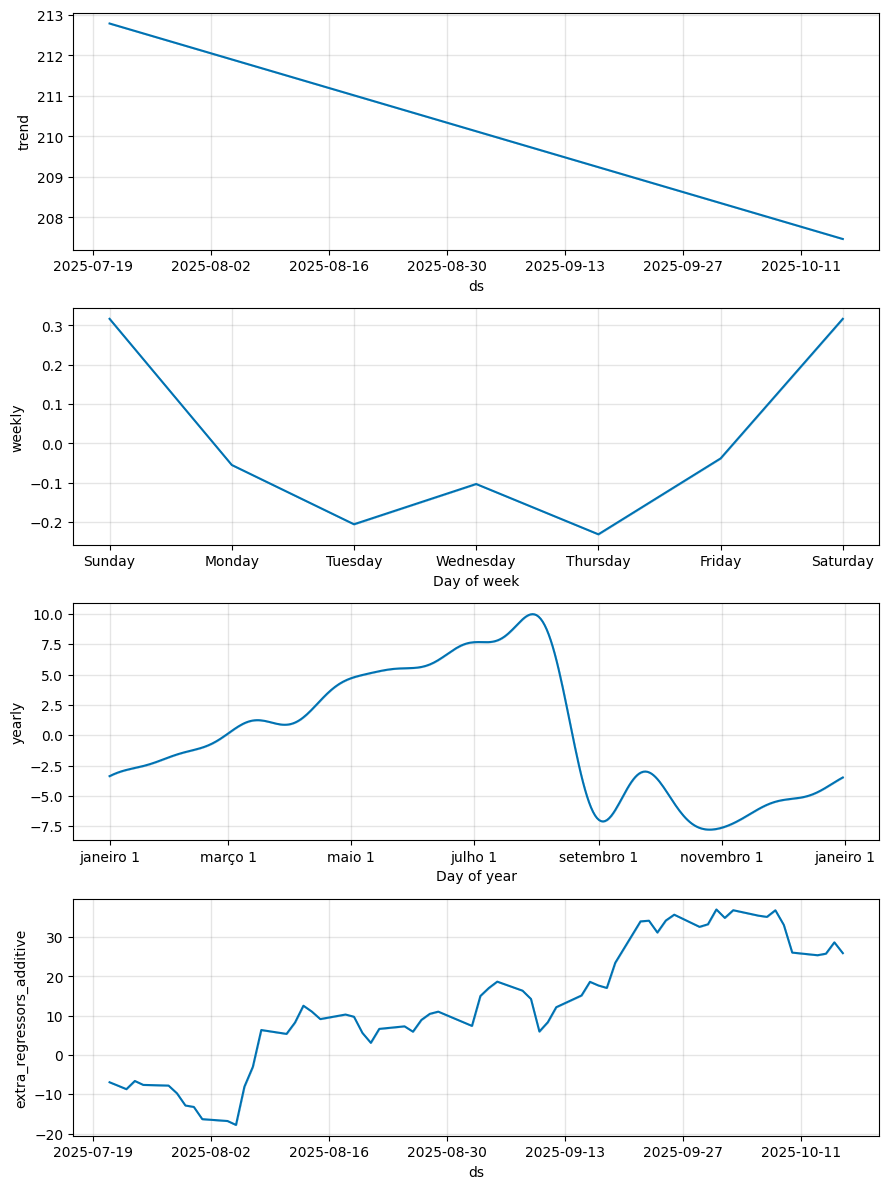

In [53]:
fig2 = model.plot_components(forecast)

In [ ]:
forecast.head()
test.head()

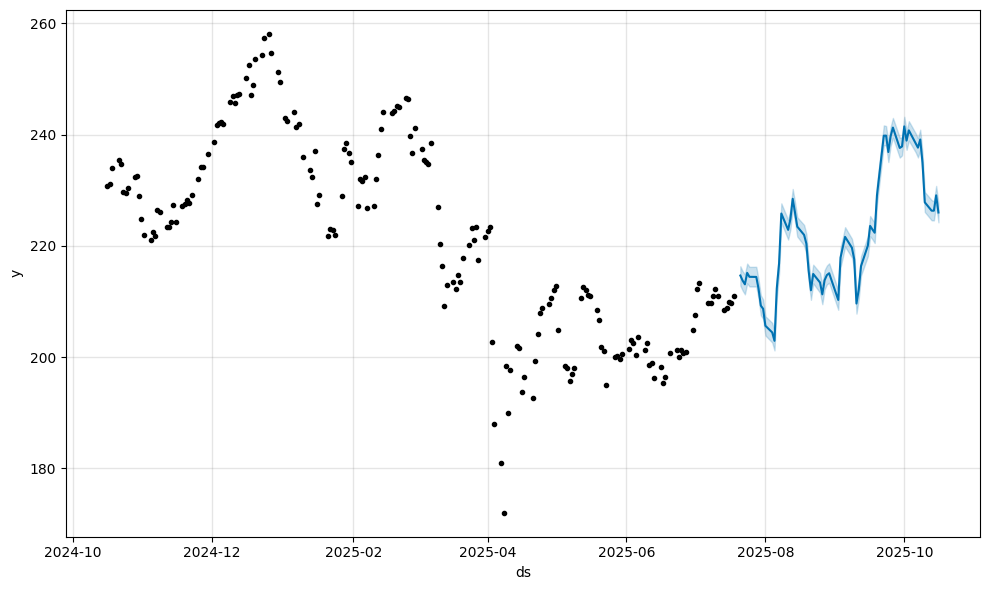

In [59]:
fig = model.plot(forecast)

In [62]:
future_on = forecast.tail(60)
fig = go.Figure()
fig.add_trace(go.Scatter(x=future_on['ds'], y=future_on['yhat'], name='Forecast'))
fig.add_trace(go.Scatter(x=future_on['ds'], y=future_on['yhat_lower'], name='Forecast Lower', line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=future_on['ds'], y=future_on['yhat_upper'], name='Forecast Upper', line=dict(width=0), fill='tonexty', showlegend=False))
fig.update_layout(title='Prophet Model - Previsão para os Próximos 60 Dias',
                  xaxis_title='Date',   
                  yaxis_title='Preço')

In [65]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(
    model,
    initial='200 days',
    period='90 days',
    horizon='60 days'
)

df_p = performance_metrics(df_cv)
df_p.head()


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

14:44:47 - cmdstanpy - INFO - Chain [1] start processing
14:44:48 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,10.010255,3.163899,3.000701,0.015015,0.015368,0.014889,0.25
1,8 days,10.180087,3.190625,3.051167,0.015330,0.015368,0.015202,0.25
2,9 days,10.191138,3.192356,3.052703,0.015375,0.015458,0.015246,0.25
3,10 days,8.905797,2.984258,2.721357,0.013739,0.013448,0.013626,0.50
4,11 days,4.448114,2.109055,1.706953,0.008532,0.007656,0.008477,0.75
